In [1]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

# Other modules
from pathlib import Path
from glob import glob
from tqdm.notebook import tqdm
from plot_keras_history import plot_history

Use the Distiller class as provided

In [2]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

We now load the data that will be used for our models

In [3]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../Part_1')
MODEL = Path(MODEL_FOLDER / 'chinese_traffic_sign_classifier_v1.h5')

Same as in 5.1, we load the data, and create a model, that will be our teacher.

In [4]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)

# Probably a better approach: filter all rows in the csv, then load only corresponding images...
for idx in range(len(images)):
    # get label specific to this image
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if label == 0 or label == 1:
        
        img_bgr = cv2.imread(full_img_path)
        image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMG_SIZE)
        image = img_to_array(image)
        dataset.append(image)
        labels.append(label)

print(f'There are {len(dataset)} images in the dataset')

dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels, test_size=0.2)

There are 158 images in the dataset


In [6]:
def create_model(input_dims, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_dims))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(32, (5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Flatten())  
    model.add(Dense(64, activation='relu',))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

teacher = create_model(train_X[0,:].shape, train_Y.shape[1])
student = create_model(train_X[0,:].shape, train_Y.shape[1])

We now train the teacher model the usual way

In [7]:
IMAGE_SIZE = (134,128)
BS = 128
EPOCHS = 100

es = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.001, verbose=1,
                   restore_best_weights=True, mode='min')

history = teacher.fit(train_X, train_Y, batch_size=BS, epochs=EPOCHS, callbacks=[es],
                      validation_data=(valid_X, valid_Y))

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6947 - accuracy: 0.5159 - val_loss: 0.6779 - val_accuracy: 0.7500
Epoch 2/100
1/1 [==============================] - 1s 984ms/step - loss: 0.7310 - accuracy: 0.7460 - val_loss: 0.5817 - val_accuracy: 0.7500
Epoch 3/100
1/1 [==============================] - 1s 989ms/step - loss: 0.5785 - accuracy: 0.7460 - val_loss: 0.5363 - val_accuracy: 0.7500
Epoch 4/100
1/1 [==============================] - 1s 836ms/step - loss: 0.5459 - accuracy: 0.7460 - val_loss: 0.5259 - val_accuracy: 0.7500
Epoch 5/100
1/1 [==============================] - 1s 805ms/step - loss: 0.5350 - accuracy: 0.7460 - val_loss: 0.5178 - val_accuracy: 0.7500
Epoch 6/100
1/1 [==============================] - 1s 814ms/step - loss: 0.5338 - accuracy: 0.7460 - val_loss: 0.5070 - val_accuracy: 0.7500
Epoch 7/100
1/1 [==============================] - 1s 806ms/step - loss: 0.5107 - accuracy: 0.7460 - val_loss: 0.4982 - val_accuracy: 0.7500
Epoch 8/100
1/1 

Epoch 59/100
1/1 [==============================] - 1s 928ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 60/100
1/1 [==============================] - 1s 917ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 1s 863ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 1s 1s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 63/100
1/1 [==============================] - 1s 948ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 64/100
1/1 [==============================] - 1s 871ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 65/100
1/1 [==============================] - 1s 831ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 66/

We plot the loss and accuracy curves, and evaluate the model

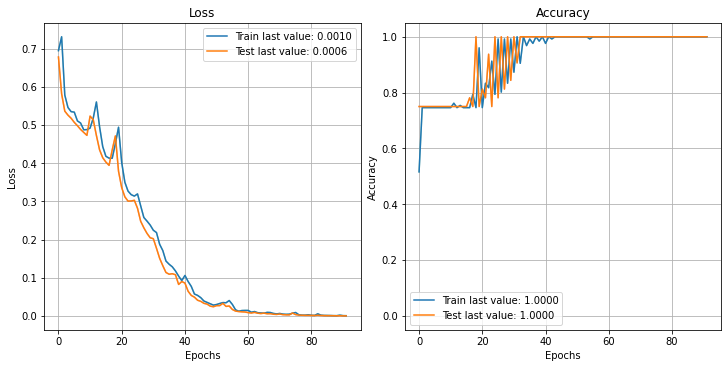

1/1 [==============================] - 0s 192ms/step - loss: 0.0015 - accuracy: 1.0000


[0.0014654304832220078, 1.0]

In [8]:
plot_history(history.history)
plt.show()
teacher.evaluate(valid_X, valid_Y)

Ok, now we are ready to use the distiller class to train our student

In [9]:
EPOCHS = 200

distiller = Distiller(student=student, teacher=teacher)

distiller.compile(optimizer='adam', metrics=['categorical_crossentropy'],
                  student_loss_fn=keras.losses.CategoricalCrossentropy(),
                  distillation_loss_fn=keras.losses.KLDivergence(),
                  alpha=0.1, temperature=10)

es = EarlyStopping(monitor='student_loss', patience=10, min_delta=0.001, verbose=1,
                   restore_best_weights=True, mode='min')

history_d = distiller.fit(train_X, train_Y, batch_size=BS, epochs=EPOCHS, callbacks=[es],
                      validation_data=(valid_X, valid_Y))

Epoch 1/200
1/1 [==============================] - 2s 2s/step - categorical_crossentropy: 0.5947 - student_loss: 0.5947 - distillation_loss: 0.0010 - val_categorical_crossentropy: 0.5294 - val_student_loss: 0.5294
Epoch 2/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.5512 - student_loss: 0.5512 - distillation_loss: 9.1509e-04 - val_categorical_crossentropy: 0.5298 - val_student_loss: 0.5298
Epoch 3/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.5638 - student_loss: 0.5638 - distillation_loss: 9.3227e-04 - val_categorical_crossentropy: 0.5107 - val_student_loss: 0.5107
Epoch 4/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.5292 - student_loss: 0.5292 - distillation_loss: 8.7441e-04 - val_categorical_crossentropy: 0.5020 - val_student_loss: 0.5020
Epoch 5/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.5305 - student_loss: 0.5305 - distillati

1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0646 - student_loss: 0.0646 - distillation_loss: 7.5859e-05 - val_categorical_crossentropy: 0.0371 - val_student_loss: 0.0371
Epoch 39/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0513 - student_loss: 0.0513 - distillation_loss: 4.7960e-05 - val_categorical_crossentropy: 0.0395 - val_student_loss: 0.0395
Epoch 40/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0583 - student_loss: 0.0583 - distillation_loss: 5.7393e-05 - val_categorical_crossentropy: 0.0328 - val_student_loss: 0.0328
Epoch 41/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0422 - student_loss: 0.0422 - distillation_loss: 3.2913e-05 - val_categorical_crossentropy: 0.0266 - val_student_loss: 0.0266
Epoch 42/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0265 - student_loss: 0.0265 - distillation_l

1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0023 - student_loss: 0.0023 - distillation_loss: 3.1728e-07 - val_categorical_crossentropy: 0.0018 - val_student_loss: 0.0018
Epoch 76/200
1/1 [==============================] - 1s 1s/step - categorical_crossentropy: 0.0049 - student_loss: 0.0049 - distillation_loss: 2.0960e-06 - val_categorical_crossentropy: 0.0015 - val_student_loss: 0.0015
Epoch 77/200
1/1 [==============================] - 2s 2s/step - categorical_crossentropy: 0.0022 - student_loss: 0.0022 - distillation_loss: 2.4307e-07 - val_categorical_crossentropy: 0.0014 - val_student_loss: 0.0014
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping


Ok, now we can plot the history and see the evolution of loss and accuracy

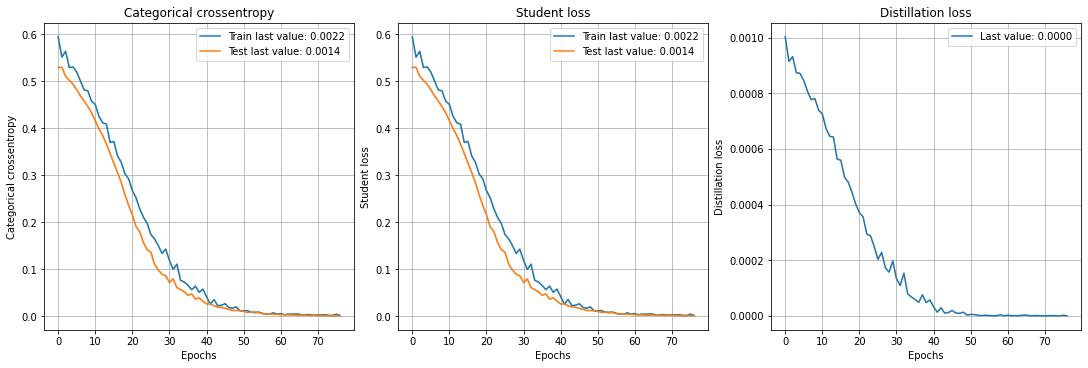

In [10]:
plot_history(history_d.history)
plt.show()

Looks good! Now, we compute the accuracy on the validation data.

In [11]:
pred = student.predict(valid_X)
acc = np.sum(np.argmax(pred, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on input dataset: {acc * 100:.2f}%")

Accuracy on input dataset: 100.00%


As expected, the accuracy is very high on the simple dataset with only two classes. Let's proceed by creating some corrupted inputs, using FGSM method.

In [14]:
EPSILON = 0.03

valid_X_fgsm = fast_gradient_method(student, valid_X, EPSILON, np.inf)

Finally, we compute the accuracy of the model on the corrupted data

In [15]:
pred_fgsm = student.predict(valid_X_fgsm)
acc_fgsm = np.sum(np.argmax(pred_fgsm, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on fgsm-corrupted dataset: {acc_fgsm * 100:.2f}%")

Accuracy on fgsm-corrupted dataset: 90.62%
